In [1]:
import numpy as np 
import pandas as pd 
import six
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn import tree
from sklearn import ensemble
from sklearn.metrics import mean_absolute_error
import joblib
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn import metrics
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

print('The joblib version is {}.'.format(joblib.__version__))
#import scikitplot as skplt


Wetterdata=pd.read_csv('../data/wetter/wetter_19560101_20190226_ohne_Sonne.csv')
#Wetterdata=pd.read_csv('../data/wetter/wetter_20170826_20190226_ohne_Sonne.csv')
#Wetterdata=pd.read_csv('../data/wetter/vorheriger_Tag.csv')

df = pd.DataFrame(Wetterdata.head(1))

# plt.savefig('../static/images/wetterdaten_ohne_Sonne.png')



The joblib version is 0.13.2.
['wetter_19510101_20181231_orig.csv', 'y_test.csv', 'wetter_20170924_20190327_orig.txt', 'X_test_vor.csv', 'wetter_20170826_20190226_ohne_Sonne_animation.csv', 'wetter_20170826_20190226_ohne_Sonne.csv', 'wetter_19560101_20190226_ohne_Sonne.csv', 'X_test.csv', 'wetter_20170826_20190226.csv', 'y_train_vor.csv', 'params_train.csv', 'wetter_19560101_20170826.csv', 'X_train_vor.csv', 'params_test.csv', 'X_train.csv', 'y_test_vor.csv', 'wetter_19560101_20170826_ohne_Sonne.csv', 'wetter_20170826_20190226_orig.csv', 'wetter_20170826_20190226_klein.csv', 'y_train.csv', 'wetter_20170924_20190327_orig.csv', 'X_train_no_header.csv', 'X_test_no_header.csv', 'vorheriger_Tag.csv']


In [2]:
y = Wetterdata['Niederschlagsform']
del Wetterdata['Niederschlagsform']

featurenames = Wetterdata.columns

X = Wetterdata
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)


#Create necessary csv-files. Do this only on first execution
# X_test.to_csv("../data/wetter/X_test.csv", header = True, index=False)
# X_train.to_csv("../data/wetter/X_train.csv", header = True, index=False)
# y_train.to_csv("../data/wetter/y_train.csv", header = True, index=False)
# y_test.to_csv("../data/wetter/y_test.csv", header = True, index=False)

# X_test.to_csv("../data/wetter/X_test_vor.csv", header = True, index=False)
# X_train.to_csv("../data/wetter/X_train_vor.csv", header = True, index=False)
# y_train.to_csv("../data/wetter/y_train_vor.csv", header = True, index=False)
# y_test.to_csv("../data/wetter/y_test_vor.csv", header = True, index=False)



In [4]:
selector = ensemble.RandomForestClassifier(n_estimators=10) 
rfecv = RFECV(estimator=selector, step=1, cv=5,scoring='accuracy') 
rfecv = rfecv.fit(X_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])
print(rfecv.estimator_.feature_importances_ )

Optimal number of features : 11
Best features : Index(['Wind_max', 'Wind_mittel', 'Schneehöhe', 'Bedeckungsgrad', 'Dampfdruck',
       'Luftdruck', 'Temp_mittel', 'rel_Feuchte', 'Temp_max_2m', 'Temp_min_2m',
       'Temp_min_5cm'],
      dtype='object')
[0.10579203 0.05747825 0.00608859 0.24612423 0.05901202 0.13126274
 0.05655483 0.162494   0.06153762 0.05483815 0.05881753]


Simple Dec Tree accuracy on the training set: 0.8160584846044235
Simple Dec Tree accuracy on the test set: 0.8025440878866724
                        Predicted No precipitation  Predicted precipitation
True Not precipitation                        1636                      948
True precipitation                             418                     3916
sens 0.9035532994923858
spez 0.6331269349845201
rtrain 0.910164321558595
rtest 0.9035532994923858
Parameter of simple decision Tree:  {'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 4, 'splitter': 'best'}


[Text(0, 0.5, 'kein Spam'), Text(0, 1.5, 'Spam')]

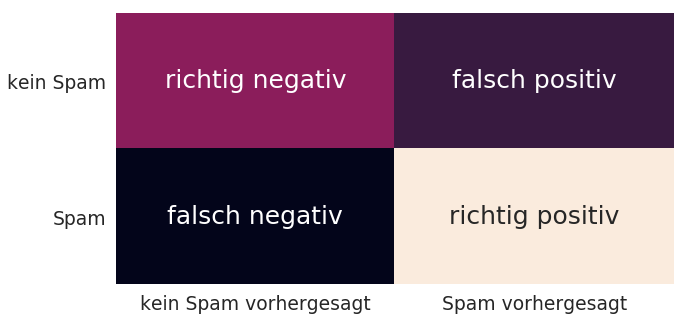

In [12]:
clf = tree.DecisionTreeClassifier(random_state=4, max_depth=5)

#Simple Decision Tree without modifications

clf.fit(X_train, y_train)
dtPredictionsTrain = clf.predict(X_train)
dtPredictionsTest = clf.predict(X_test)

print("Simple Dec Tree accuracy on the training set:", accuracy_score(y_train, dtPredictionsTrain))
print("Simple Dec Tree accuracy on the test set:", accuracy_score(y_test, dtPredictionsTest))

print(pd.DataFrame(
    confusion_matrix(y_test, dtPredictionsTest),
    columns=['Predicted No precipitation', 'Predicted precipitation'],
    index=['True Not precipitation', 'True precipitation']
))


tn, fp, fn, tp = confusion_matrix(y_test, dtPredictionsTest).ravel()
specificity = tn/(tn+fp)
sensitivity = tp/(tp+fn)
recall_train = recall_score(y_train, dtPredictionsTrain)
recall_test = recall_score(y_test, dtPredictionsTest)
print("sens",sensitivity)
print("spez", specificity)
print("rtrain", recall_train)
print("rtest", recall_test)

# cm_train = confusion_matrix(y_train,dtPredictionsTrain)
# cm_test = confusion_matrix(y_test, dtPredictionsTest)
# print("Parameter of simple decision Tree: ", clf.get_params())
# cm_helper = np.zeros((3,3))
# cm_helper[:-1,:-1] = cm_test
# cm_helper[0,2] = cm_helper[0,0] + cm_helper[0,1]
# cm_helper[1,2] = cm_helper[1,0] + cm_helper[1,1]
# cm_helper[2,0] = cm_helper[0,0] + cm_helper[1,0]
# cm_helper[2,1] = cm_helper[0,1] + cm_helper[1,1]
# cm_helper[2,2] = cm_helper[0,2] + cm_helper[1,2]


# sn.set(font_scale=1.7)#for label size
# #sn.heatmap(cm_train, annot=True,annot_kws={"size": 15}, fmt='.5g')
# plt.figure(figsize = (10,5))
# plt.yticks(rotation=0)
# labels =  np.array([['richtig negativ','falsch positiv'],['falsch negativ','richtig positiv']])
# plot = sn.heatmap(cm_test, cbar=False, annot=labels,annot_kws={"size": 25}, fmt='', xticklabels=["kein Spam vorhergesagt", "Spam vorhergesagt"], yticklabels=["kein Spam", "Spam"])
# plot.set_yticklabels(plot.get_yticklabels(), rotation = 0)

In [15]:
param_grid = {
    'max_depth': [3,4,11, None],
    'min_samples_leaf': [1,2,3,78],
    'min_samples_split':[2,3,4,5,7,34],
    'max_features': [None,10],
    'criterion': ['gini','entropy'],
    'random_state': [4,793]
}

GS_clf = GridSearchCV(clf, param_grid, n_jobs=-1)

GS_clf.fit(X_train, y_train)
print('best score: ', GS_clf.best_score_)
print("best params -", GS_clf.best_params_)


/home/Uni/blaucloud/Informatik/Arbeit/ml/env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


best score:  0.8135183693699275
best params - {'criterion': 'entropy', 'max_depth': 11, 'max_features': 10, 'min_samples_leaf': 78, 'min_samples_split': 2, 'random_state': 4}


In [16]:
clfBestParams = GS_clf.best_estimator_
clfBestParams.fit(X_train, y_train)

decisionTreePredictionsTrain = clfBestParams.predict(X_train)

decisionTreePredictionsTest = clfBestParams.predict(X_test)


print("Tuned Tree accuracy on the training set:", accuracy_score(y_train, decisionTreePredictionsTrain))
print("Tuned Tree accuracy on the test set:", accuracy_score(y_test, decisionTreePredictionsTest))


Dec Tree accuracy on the training set: 0.8271482559940524
Dec Tree accuracy on the test set: 0.8071697022260769


In [7]:
#New approach using RandomizedSearchCV

from sklearn.model_selection import RandomizedSearchCV
import sys

criterion = ['gini', 'entropy']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 20, num = 10)]
max_features = [int(x) for x in np.linspace(start = 1, stop = 11, num = 11)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 100, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 100, num = 10)]
random_state = [int(x) for x in np.linspace(start = 0, stop = 2000, num = 200)]

random_grid = {'criterion': criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'random_state': random_state}

dt = tree.DecisionTreeClassifier()
dt_random = RandomizedSearchCV(estimator = dt, param_distributions = random_grid, n_iter = 1000, cv = 2, verbose=2, random_state=42, n_jobs = -1)
dt_random.fit(X_train, y_train)

print(dt_random.best_params_)

base_model = clf

base_accuracy = accuracy_score(y_test, dtPredictionsTest)
print("base_accuracy: ",base_accuracy)
best_random = dt_random.best_estimator_
dt_randomPredictionsTest = dt_random.predict(X_test)
random_accuracy = accuracy_score(y_test, dt_randomPredictionsTest)
print("random_accuracy: ",random_accuracy)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))



Fitting 2 folds for each of 1000 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 592 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 1404 tasks      | elapsed:   16.4s


{'random_state': 1768, 'min_samples_split': 78, 'min_samples_leaf': 100, 'max_features': 8, 'max_depth': 9, 'criterion': 'entropy'}
base_accuracy:  0.6284516408847767
random_accuracy:  0.7143270203845598
Improvement of 13.66%.


[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   23.2s finished


In [8]:
print(pd.DataFrame(
    confusion_matrix(y_test, decisionTreePredictionsTest),
    columns=['Predicted No precipitation', 'Predicted precipitation'],
    index=['True Not precipitation', 'True precipitation']
))

                        Predicted No precipitation  Predicted precipitation
True Not precipitation                        1184                     1394
True precipitation                             643                     3696


In [9]:
tn, fp, fn, tp = confusion_matrix(y_test, decisionTreePredictionsTest).ravel()
specificity = tn/(tn+fp)
sensitivity = tp/(tp+fn)

print("sensitivity", sensitivity)
print("Specificity", specificity)

sensitivity 0.8518091726204194
Specificity 0.45927075252133437


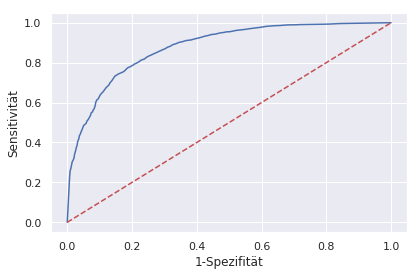

0.8772650569833744


In [19]:
def roc(clf):
    # calculate the fpr and tpr for all thresholds of the classification
    probs = clf.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    
    plt.plot(fpr,tpr)
    #plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([1, 0])
    plt.xticks([1.0,0.8,0.6,0.4,0.2,0.0], [0.0,0.2,0.4,0.6,0.8,1.0])
    plt.ylim([0, 1])
    plt.ylabel('Sensitivität')
    plt.xlabel('Spezifität')
    
    plt.tight_layout()
    plt.show()
    print(roc_auc)
    
def sens(clf):
    probs = clf.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
     
    plt.plot(threshold,tpr)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Sensitivität')
    plt.xlabel('Schwellenwert')
    
    plt.tight_layout()
    plt.show()
    
def spez(clf):
    probs = clf.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    
    plt.plot(threshold,1-fpr)

    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Spezifität')
    plt.xlabel('Schwellenwert')
    
    plt.tight_layout()
    plt.show()
    
def sensspez(clf):
    probs = clf.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.subplot(221)
    plt.plot(threshold,tpr)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Sensitivität')
    plt.xlabel('Schwellenwert')
    
    plt.subplot(222)
    plt.plot(threshold,1-fpr)

    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Spezifität')
    plt.xlabel('Schwellenwert')
    
    plt.tight_layout()
    plt.show()

roc(clfBestParams)

/home/Uni/blaucloud/Informatik/Arbeit/ml/env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest accuracy on the training set: 0.98804139042072
Random Forest accuracy on the test set: 0.6797744687003036
                        Predicted No precipitation  Predicted precipitation
True Not precipitation                        1447                     1131
True precipitation                            1084                     3255
sensitivity 0.7501728508873012
Specificity 0.5612878200155159


/home/Uni/blaucloud/Informatik/Arbeit/ml/env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


     pred_neg  pred_pos
neg       271      2307
pos        80      4259
tp_opt, fn_opt 4259 80
Sensitivity optimised 0.981562572021203
Specificity optimised 0.10512024825446083
Random Forest optimised accuracy on the training set: 0.7971373691058926
Random Forest optimised accuracy on the test set: 0.6549081971953159


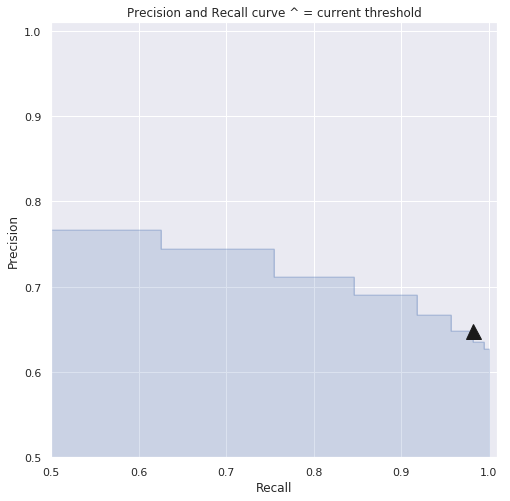

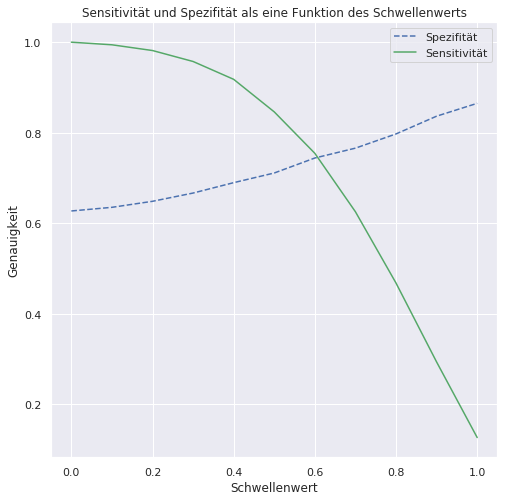

In [13]:
#Random Forest
rf = ensemble.RandomForestClassifier(random_state=7)
rf.fit(X_train, y_train)

rfPredictionsTrain = rf.predict(X_train)

rfPredictionsTest = rf.predict(X_test)


print("Random Forest accuracy on the training set:", accuracy_score(y_train, rfPredictionsTrain))

print("Random Forest accuracy on the test set:", accuracy_score(y_test, rfPredictionsTest))

#Sensitivity and Specificity
print(pd.DataFrame(
    confusion_matrix(y_test, rfPredictionsTest),
    columns=['Predicted No precipitation', 'Predicted precipitation'],
    index=['True Not precipitation', 'True precipitation']
))

tn, fp, fn, tp = confusion_matrix(y_test, rfPredictionsTest).ravel()
specificity = tn/(tn+fp)
sensitivity = tp/(tp+fn)

print("sensitivity", sensitivity)
print("Specificity", specificity)

#Optimized Random Forest
rf_opt = ensemble.RandomForestClassifier(n_jobs=-1, random_state=1)

# param_grid = {
#     'min_samples_split': [3, 5, 10], 
#     'n_estimators' : [100, 300],
#     'max_depth': [3, 5, 15, 25],
#     'max_features': [3, 5, 10, 20]
# }

# scorers = {
#     'precision_score': make_scorer(precision_score),
#     'recall_score': make_scorer(recall_score),
#     'accuracy_score': make_scorer(accuracy_score)
# }


# def grid_search_wrapper(refit_score='precision_score'):
#     print("test")
#     """
#     fits a GridSearchCV classifier using refit_score for optimization
#     prints classifier performance metrics
#     """
#     skf = StratifiedKFold(n_splits=10)
#     grid_search = GridSearchCV(rf_opt, param_grid, scoring=scorers, refit=refit_score,
#                            cv=skf, return_train_score=True, n_jobs=-1)
#     grid_search.fit(X_train, y_train)

#     # make the predictions
#     y_pred = grid_search.predict(X_test)

#     print('Best params for {}'.format(refit_score))
#     print(grid_search.best_params_)

#     # confusion matrix on the test data.
#     print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
#     print(pd.DataFrame(confusion_matrix(y_test, y_pred),
#                  columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
#     return grid_search

#grid_search_rf = grid_search_wrapper(refit_score='precision_score')

rf_opt.fit(X_train, y_train)
y_scores = rf_opt.predict_proba(X_test)[:,1]
p, r, thresholds = precision_recall_curve(y_test, y_scores)


def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    tn_opt, fp_opt, fn_opt, tp_opt = confusion_matrix(y_test, y_pred_adj).ravel()
    specificity_opt = tn_opt/(tn_opt+fp_opt)
    sensitivity_opt = tp_opt/(tp_opt+fn_opt)

    print("tp_opt, fn_opt", tp_opt, fn_opt)
    print("Sensitivity optimised", sensitivity_opt)
    print("Specificity optimised", specificity_opt)
    
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)
    
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Sensitivität und Spezifität als eine Funktion des Schwellenwerts")
    plt.plot(thresholds, precisions[:-1], "b--", label="Spezifität")
    plt.plot(thresholds, recalls[:-1], "g-", label="Sensitivität")
    plt.ylabel("Genauigkeit")
    plt.xlabel("Schwellenwert")
    #plt.set_xtickslabels(['0'])
    plt.legend(loc='best')
    
threshold = 0.2
precision_recall_threshold(p, r, thresholds, threshold)
plot_precision_recall_vs_threshold(p, r, thresholds)

rf_optPredictionsTrain = rf_opt.predict(X_train)

rf_optPredictionsTest = rf_opt.predict(X_test)


predicted_probaTrain = rf_opt.predict_proba(X_train)
rf_optPredictionsTrain = (predicted_probaTrain [:,1] >= threshold).astype('int')

predicted_probaTest = rf_opt.predict_proba(X_test)
rf_optPredictionsTest = (predicted_probaTest [:,1] >= threshold).astype('int')


print("Random Forest optimised accuracy on the training set:", accuracy_score(y_train, rf_optPredictionsTrain))

print("Random Forest optimised accuracy on the test set:", accuracy_score(y_test, rf_optPredictionsTest))


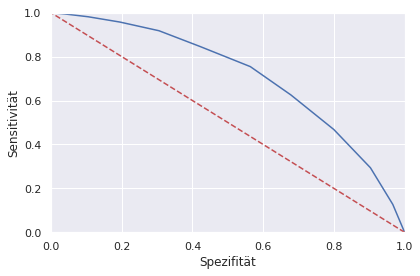

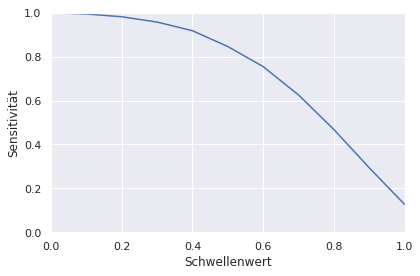

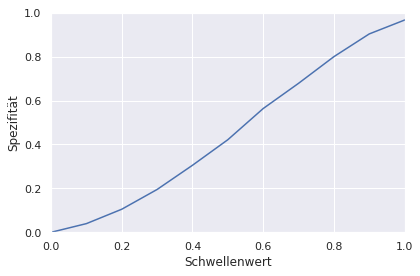

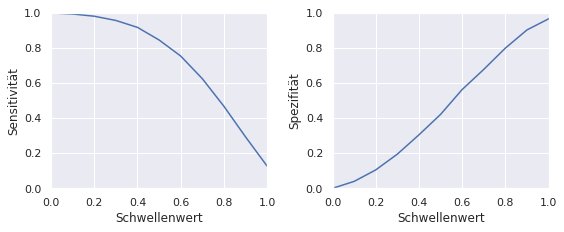

In [14]:
roc(rf_opt)
sens(rf_opt)
spez(rf_opt)
sensspez(rf_opt)

K Nearest Neighbors accuracy on the training set: 0.7276782948138051
K Nearest Neighbors accuracy on the test set: 0.7089778805840682


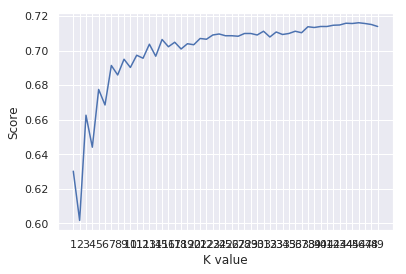

Maximum KNN Score is 71.61% at
[46]
                        Predicted No precipitation  Predicted precipitation
True Not precipitation                        1262                     1316
True precipitation                             697                     3642
sensitivity 0.8393639087347315
Specificity 0.4895267649340574


In [15]:
#KNN
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=30)
knn.fit(X_train, y_train)

knnPredictionsTrain = knn.predict(X_train)

knnPredictionsTest = knn.predict(X_test)


print("K Nearest Neighbors accuracy on the training set:", accuracy_score(y_train, knnPredictionsTrain))

print("K Nearest Neighbors accuracy on the test set:", accuracy_score(y_test, knnPredictionsTest))

scoreList = []
for i in range(1,50):
    knn2 = KNeighborsClassifier(n_neighbors = i)
    knn2.fit(X_train, y_train)
    scoreList.append(knn2.score(X_test, y_test))
    
plt.plot(range(1,50), scoreList)
plt.xticks(np.arange(1,50,1))
plt.xlabel("K value")
plt.ylabel("Score")
plt.show()

m = max(scoreList)
[i for i, j in enumerate(scoreList) if j == m]

print("Maximum KNN Score is {:.2f}% at".format(m*100))
print([i+1 for i, j in enumerate(scoreList) if j == m])
#Sensitivity and Specificity
print(pd.DataFrame(
    confusion_matrix(y_test, knnPredictionsTest),
    columns=['Predicted No precipitation', 'Predicted precipitation'],
    index=['True Not precipitation', 'True precipitation']
))
tn, fp, fn, tp = confusion_matrix(y_test, knnPredictionsTest).ravel()
specificity = tn/(tn+fp)
sensitivity = tp/(tp+fn)

print("sensitivity", sensitivity)
print("Specificity", specificity)


In [8]:
#Store models permanently
# dtModel_GS = open("models/dtmodel_gs.pkl","wb")
# joblib.dump(GS_clf,dtModel_GS)
# dtModel_GS.close

# dtModel_simple = open("models/dtmodel_simple.pkl", "wb")
# joblib.dump(clf, dtModel_simple)
# dtModel_simple.close

# knn_model = open("models/knn_model.pkl", "wb")
# joblib.dump(knn, knn_model)
# knn_model.close

# rf_model = open("models/rf_model.pkl", "wb")
# joblib.dump(rf, rf_model)
# rf_model.close

# rf_opt_model = open("models/rf_opt_model.pkl", "wb")
# joblib.dump(rf_opt, rf_opt_model)
# rf_opt_model.close

In [19]:
# from IPython.display import Image
# import pydot
# from six import StringIO

# dot_data = StringIO()
# tree.export_graphviz(clf, out_file='wetter_tree_ohne_Sonne.dot', feature_names= X_train.columns,
#                                 class_names= ['kein Regen', 'Regen'],
#                                 filled=True, rounded=True,
#                                 special_characters=True)

In [21]:
# !dot -T png wetter_tree_ohne_Sonne.dot -o ../static/images/wetter_tree_ohne_Sonne.png

In [19]:
# #clf_2 for other Decision Tree Example
# clf_2 = tree.DecisionTreeClassifier(random_state=333, criterion='gini', min_samples_leaf=6, max_features=0.1)
# clf_2.fit(X_train,y_train)
# dt2PredictionsTrain = clf_2.predict(X_train)
# dt2PredictionsTest = clf_2.predict(X_test)

# print("Simple Dec Tree 2 accuracy on the training set:", accuracy_score(y_train, dt2PredictionsTrain))
# print("Simple Dec Tree 2 accuracy on the test set:", accuracy_score(y_test, dt2PredictionsTest))

# tree.export_graphviz(clf_2, out_file='wetter_tree_ohne_Sonne_2.dot', feature_names= X_train.columns,
#                                 class_names= ['0', '1'],
#                                 filled=True, rounded=True,
#                                 special_characters=True)

# !dot -T png wetter_tree_ohne_Sonne_2.dot -o ../static/images/wetter_tree_ohne_Sonne_2.png

# tree.export_graphviz(clfBestParams, out_file='wetter_tree_ohne_Sonne_gs.dot', feature_names= X_train.columns,
#                                 class_names= ['0', '1'],
#                                 filled=True, rounded=True,
#                                 special_characters=True)

# !dot -T png wetter_tree_ohne_Sonne_gs.dot -o ../static/images/wetter_tree_ohne_Sonne_gs.png

In [20]:
#Tree for Animation

# AnimationData=pd.read_csv('../data/wetter/wetter_20170826_20190226_ohne_Sonne_animation.csv')
# y_anim = AnimationData['Niederschlagsform']

# del AnimationData['Niederschlagsform']


# X_anim = AnimationData
# X_anim_train, X_anim_test, y_anim_train, y_anim_test = train_test_split(X_anim, y_anim, test_size=0.3, random_state=1)


# animation = tree.DecisionTreeClassifier(random_state=3, criterion='gini', min_samples_leaf=5, max_features=1, max_depth=3)
# animation.fit(X_anim_train,y_anim_train)
# animationPredictionsTrain = animation.predict(X_anim_train)
# animationPredictionsTest = animation.predict(X_anim_test)

# print("Animation accuracy on the training set:", accuracy_score(y_anim_train, animationPredictionsTrain))
# print("Animation accuracy on the test set:", accuracy_score(y_anim_test, animationPredictionsTest))

# tree.export_graphviz(animation, out_file='wetter_tree_ohne_Sonne_animation.dot', feature_names= X_anim_train.columns,
#                                 class_names= ['0', '1'],
#                                 filled=True, rounded=True,
#                                 special_characters=True)

# !dot -T png -Gdpi=600 wetter_tree_ohne_Sonne_animation.dot -o ../static/images/wetter_tree_ohne_Sonne_animation.png

In [21]:
#Trees for different parameter explanation

# for i in np.arange(1,5):
#     t = tree.DecisionTreeClassifier(max_depth=i)
#     t.fit(X_train, y_train)
#     tree.export_graphviz(t, out_file='max_depth_{}.dot'.format(i), feature_names= X_train.columns,
#                                 class_names= ['0', '1'],
#                                 filled=True, rounded=True,
#                                 special_characters=True)

# !dot -T png -Gdpi=300 max_depth_1.dot -o ../static/images/max_depth_1.png
# !dot -T png -Gdpi=300 max_depth_2.dot -o ../static/images/max_depth_2.png
# !dot -T png -Gdpi=300 max_depth_3.dot -o ../static/images/max_depth_3.png
# !dot -T png -Gdpi=300 max_depth_4.dot -o ../static/images/max_depth_4.png